### Prepare for network training

In [261]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from datetime import datetime as dt
from sklearn.decomposition import PCA
import torch

import importlib

# import disjoint_domain as dd
try:
    importlib.reload(dda)
except NameError:
    import dd_analysis as dda

try:
    importlib.reload(ddnet)
except NameError:
    import ddnet
    
try:
    importlib.reload(dd)
except NameError:
    import disjoint_domain as dd

In [273]:
def train_n_dd_nets(n=36, run_type='', net_params=None, train_params=None):

    # get some defaults
    ctx_per_domain, n_domains, n_items, n_ctx, attrs_per_context = dd.get_net_dims(attrs_per_context=60)
    device, torchfp = dd.init_torch()
    
    net_defaults = {
        'ctx_per_domain': ctx_per_domain,
        'attrs_per_context': attrs_per_context,
        'n_domains': n_domains,
        'device': device,
        'torchfp': torchfp,
        'param_init_scale': 0.01,
        'cluster_info': '4-2-2'
    }
    if net_params is None:
        net_params = {}
    net_params = {**net_defaults, **net_params}
    if net_params['device'].type == 'cuda':
        print('Using CUDA')
    else:
        print('Using CPU')
    
    train_defaults = {
        'lr': 0.01,
        'scheduler': None,
        'num_epochs': 3001,
        'batch_size': 16,
        'report_freq': 50,
        'snap_freq': 50,
        'snap_freq_scale': 'lin',
        'holdout_testing': 'none',
        'test_thresh': 0.97,
        'test_max_epochs': 10000,
        'reports_per_test': 4,
        'do_combo_testing': False
    }
    if train_params is None:
        train_params = {}
    train_params = {**train_defaults, **train_params}
    
    snaps_all = []
    reports_all = []
    parameters_all = []
    ys_all = []
    
    for i in range(n):
        print(f'Training Iteration {i+1}')
        print('---------------------')
        
        net = ddnet.DisjointDomainNet(**net_params)
        res = net.do_training(**train_params)
        
        snaps_all.append(res['snaps'])
        reports_all.append(res['reports'])
        if 'params' in res:
            parameters_all.append(res['params'])
            
        ys_all.append(net.y.cpu().numpy())

        print('')

    snaps = {}
    for snap_type in snaps_all[0].keys():
        snaps[snap_type] = np.stack([snaps_one[snap_type] for snaps_one in snaps_all])
        
    reports = {}
    for report_type in reports_all[0].keys():
        reports[report_type] = np.stack([reports_one[report_type] for reports_one in reports_all])
        
    if len(parameters_all) > 0:
        parameters = {}
        for param_type in parameters_all[0].keys():
            parameters[param_type] = np.stack([params_one[param_type] for params_one in parameters_all])
    else:
        parameters = None
        
    ys = np.stack(ys_all)
    
    if run_type != '':
        run_type += '_'

    save_name = f'data/{run_type}dd_res_{dt.now():%Y-%m-%d_%H-%M-%S}'
    res_path = save_name + '.npz'
    np.savez(res_path, snapshots=snaps, reports=reports, ys=ys, net_params=net_params,
             train_params=train_params, parameters=parameters)
    
    # save just the last net params
    net_path = save_name + '_params.pt'
    torch.save(net.state_dict(), net_path)
    
    return res_path, net_path

### Train very simple network: 2 domains, 2 clusters in each domain, one shared hidden layer, only 300 epochs with snapshots every 5.

In [240]:
net_params = {
    'use_item_repr': False,
    'use_ctx_repr': False,
    'hidden_units': 64,
    'fix_biases': True,
    'fixed_bias': 0,
    'n_domains': 2,
    'cluster_info': {
        'clusters': '4-4',
        'intragroup_dists': [4, 12]
    }
}
    
train_params = {
    'snap_freq': 5,
    'report_freq': 5,
    'num_epochs': 401
}
    
res_path, net_path = train_n_dd_nets(n=1, run_type='2domain_weight_test', net_params=net_params, train_params=train_params)

Using CUDA
Training Iteration 1
---------------------
Epoch   0 end: loss = 174.243, weighted acc = 0.197
Epoch   5 end: loss =  97.099, weighted acc = 0.461
Epoch  10 end: loss =  94.913, weighted acc = 0.462
Epoch  15 end: loss =  95.412, weighted acc = 0.466
Epoch  20 end: loss =  94.807, weighted acc = 0.466
Epoch  25 end: loss =  94.241, weighted acc = 0.466
Epoch  30 end: loss =  94.603, weighted acc = 0.462
Epoch  35 end: loss =  94.501, weighted acc = 0.465
Epoch  40 end: loss =  94.221, weighted acc = 0.469
Epoch  45 end: loss =  94.208, weighted acc = 0.468
Epoch  50 end: loss =  93.729, weighted acc = 0.470
Epoch  55 end: loss =  94.318, weighted acc = 0.467
Epoch  60 end: loss =  94.247, weighted acc = 0.470
Epoch  65 end: loss =  93.747, weighted acc = 0.466
Epoch  70 end: loss =  93.420, weighted acc = 0.466
Epoch  75 end: loss =  94.011, weighted acc = 0.469
Epoch  80 end: loss =  93.576, weighted acc = 0.467
Epoch  85 end: loss =  93.768, weighted acc = 0.466
Epoch  90 

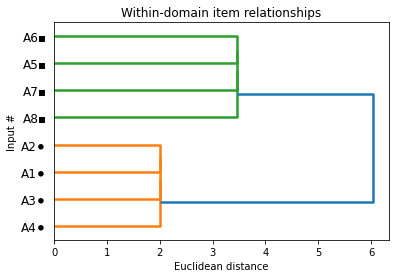

In [351]:
with np.load(res_path, allow_pickle=True) as resfile:
    snaps = resfile['snapshots'].item()
    net_params = resfile['net_params'].item()

item_names = dda._get_names_for_snapshots('item_hidden', **net_params)
    
fig, ax = dd.plot_item_attribute_dendrogram(**net_params)
ax.set_title('Within-domain item relationships')
plt.show()

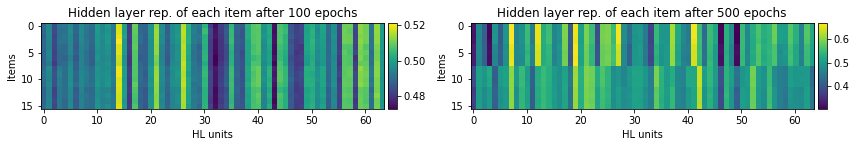

In [322]:
item_snaps = snaps['item_hidden'][0]

final_epochs = train_params['num_epochs'] - 1
epoch_snaps = dict()
epoch_snaps[100] = item_snaps[100 // train_params['snap_freq']]
epoch_snaps[final_epochs] = item_snaps[-1]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for ax, epoch in zip(axs, [100, final_epochs]):
    im = ax.imshow(epoch_snaps[epoch])
    ax.set_title(f'Hidden layer rep. of each item after {epoch} epochs')
    ax.set_ylabel('Items')
    ax.set_xlabel('HL units')
    dda.add_colorbar(im, aspect=10)
    
fig.tight_layout()
plt.show()

### After 100 and 300 epochs, all items are still very similarly represented. But there is a checkerboard pattern of cross-domain similarity:

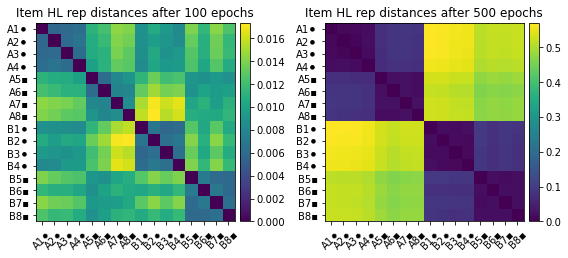

In [292]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for ax, epoch in zip(axs, [100, final_epochs]):
    rep_dist = distance.squareform(distance.pdist(epoch_snaps[epoch]))
    dda.plot_matrix_with_labels(ax, rep_dist, item_names)
    ax.set_title(f'Item HL rep distances after {epoch} epochs')

fig.tight_layout()
plt.show()

### If we look at how each item's representation differs from the mean, we see a clear division by magnitude after 100 epochs.
The "circles" have larger representations than the "squares" - although the effect is >2 orders of magnitude smaller than the size of the mean representation.

### After 300 epochs, the domains are more distinct, but the magnitude differences within each domain also persist. 

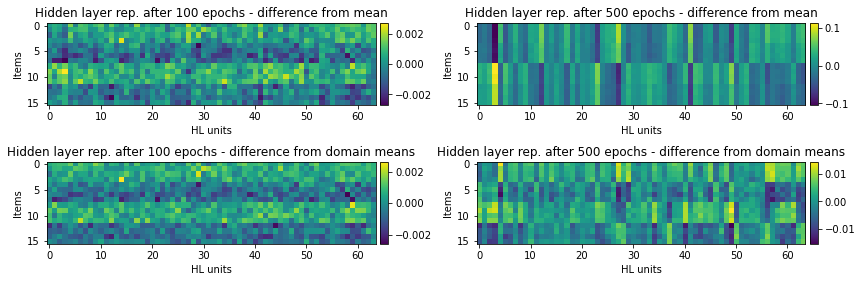

In [291]:
fig, axs = plt.subplots(2, 2, figsize=(12, 4))

for ax, epoch in zip(axs[0], [100, final_epochs]):
    im = ax.imshow(epoch_snaps[epoch] - np.mean(epoch_snaps[epoch], axis=0, keepdims=True))
    ax.set_title(f'Hidden layer rep. after {epoch} epochs - difference from mean')
    ax.set_ylabel('Items')
    ax.set_xlabel('HL units')
    dda.add_colorbar(im, aspect=10)
    
# try using individual domain means
for ax, epoch in zip(axs[1], [100, final_epochs]):
    domain1_mean = np.mean(epoch_snaps[epoch][:8], axis=0, keepdims=True)
    domain2_mean = np.mean(epoch_snaps[epoch][8:], axis=0, keepdims=True)
    perdomain_mean = np.concatenate([np.tile(domain1_mean, (8, 1)), np.tile(domain2_mean, (8, 1))], axis=0)
    
    im = ax.imshow(epoch_snaps[epoch] - perdomain_mean)
    ax.set_title(f'Hidden layer rep. after {epoch} epochs - difference from domain means')
    ax.set_ylabel('Items')
    ax.set_xlabel('HL units')
    dda.add_colorbar(im, aspect=10)
    
fig.tight_layout()
plt.show()

### Now look at the same thing with rank-order scores to see whether the effect is just due to differences in the activation distribution.

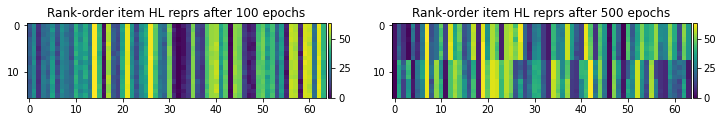

In [290]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

rank_ord_rep = dict()

for ax, epoch in zip(axs, [100, final_epochs]):
    sort_inds_each = np.argsort(epoch_snaps[epoch], axis=1)
    rank_ord_rep[epoch] = np.empty(epoch_snaps[epoch].shape)
    np.put_along_axis(rank_ord_rep[epoch], sort_inds_each, range(epoch_snaps[epoch].shape[1]), axis=1)

    im = ax.imshow(rank_ord_rep[epoch])
    ax.set_title(f'Rank-order item HL reprs after {epoch} epochs')
    dda.add_colorbar(im)

plt.show()

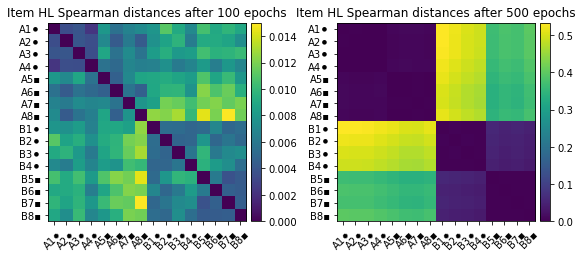

In [293]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for ax, epoch in zip(axs, [100, final_epochs]):
    spear_rep_dist = distance.squareform(distance.pdist(rank_ord_rep[epoch], 'correlation'))
    dda.plot_matrix_with_labels(ax, spear_rep_dist, item_names)
    ax.set_title(f'Item HL Spearman distances after {epoch} epochs')
    
fig.tight_layout()
plt.show()

### The cross-domain pattern is not present with Spearman correlation at 100 epochs, but emerges after 300 epochs.
* At 100 epochs, all item vectors still have about the same direction as they move toward 0, and magnitude differences are eliminated in the rank order.
* At 300 epochs, items in different domains are moving in different directions, but those with highest magnitude (circles) have the most "particular" activated hidden units and are most different from each other across domains.

### OK, the Spearman correlation pattern for all-merged isn't too mysterious. But what about when there's cross-domain similarity for both groups?
### Try same thing for "shared representation" architecture, which shows this pattern.

In [248]:
net_params_shared = {
    'merged_repr': True,
    'fix_biases': True,
    'fixed_bias': 0,
    'n_domains': 2,
    'cluster_info': {
        'clusters': '4-4',
        'intragroup_dists': [4, 12]
    }
}

train_params_shared = {
    'snap_freq': 5,
    'report_freq': 5,
    'num_epochs': 501
}

res_path_shared, net_path_shared = train_n_dd_nets(n=1, run_type='2domain_shared_bias0',
                                                   net_params=net_params_shared, train_params=train_params_shared)

Using CUDA
Training Iteration 1
---------------------
Epoch   0 end: loss = 199.371, weighted acc = 0.063
Epoch   5 end: loss =  95.236, weighted acc = 0.470
Epoch  10 end: loss =  94.674, weighted acc = 0.465
Epoch  15 end: loss =  94.749, weighted acc = 0.466
Epoch  20 end: loss =  95.384, weighted acc = 0.465
Epoch  25 end: loss =  94.616, weighted acc = 0.465
Epoch  30 end: loss =  93.768, weighted acc = 0.470
Epoch  35 end: loss =  94.022, weighted acc = 0.469
Epoch  40 end: loss =  94.673, weighted acc = 0.467
Epoch  45 end: loss =  94.320, weighted acc = 0.463
Epoch  50 end: loss =  94.645, weighted acc = 0.465
Epoch  55 end: loss =  94.720, weighted acc = 0.463
Epoch  60 end: loss =  94.093, weighted acc = 0.468
Epoch  65 end: loss =  94.365, weighted acc = 0.469
Epoch  70 end: loss =  93.658, weighted acc = 0.471
Epoch  75 end: loss =  93.606, weighted acc = 0.468
Epoch  80 end: loss =  93.683, weighted acc = 0.469
Epoch  85 end: loss =  93.759, weighted acc = 0.470
Epoch  90 

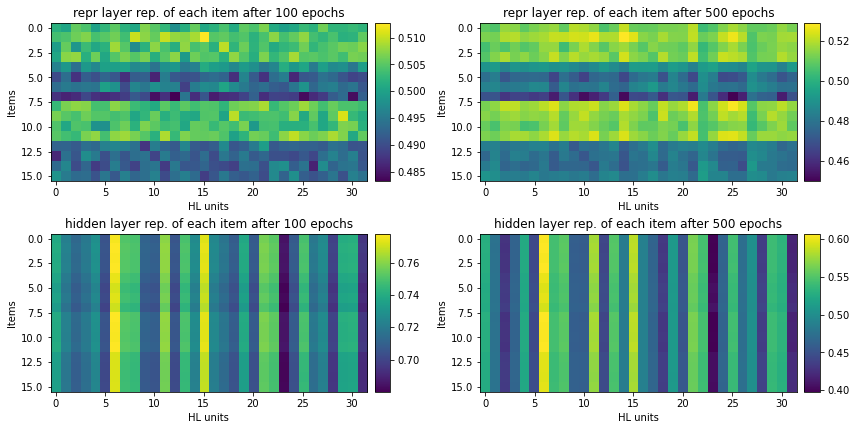

In [296]:
with np.load(res_path_shared, allow_pickle=True) as resfile:
    snaps_shared = resfile['snapshots'].item()
    net_params_shared = resfile['net_params'].item()
    
item_snaps_shared = {
    'repr': snaps_shared['item'][0],
    'hidden': snaps_shared['item_hidden'][0]
} 

final_epochs = train_params['num_epochs'] - 1
epoch_snaps_shared = {
    layer: {
        100: layer_snaps[100 // train_params['snap_freq']],
        final_epochs: layer_snaps[-1]
    } for layer, layer_snaps in item_snaps_shared.items()
}

fig, axss = plt.subplots(2, 2, figsize=(12, 6))

for axs, (layer, layer_epoch_snaps) in zip(axss, epoch_snaps_shared.items()):
    for ax, epoch in zip(axs, [100, final_epochs]):
        im = ax.imshow(layer_epoch_snaps[epoch])
        ax.set_title(f'{layer} layer rep. of each item after {epoch} epochs')
        ax.set_ylabel('Items')
        ax.set_xlabel('HL units')
        dda.add_colorbar(im, aspect=10)
    
fig.tight_layout()
plt.show()

### Looks like in this case, the group difference in magnitude is greater in both layers, and only becomes more dramatic after 300 epochs. Maybe checkerboard Spearman could be explained by a trajectory toward 0 that is curved? Check the Euclidean and Spearman distances first.

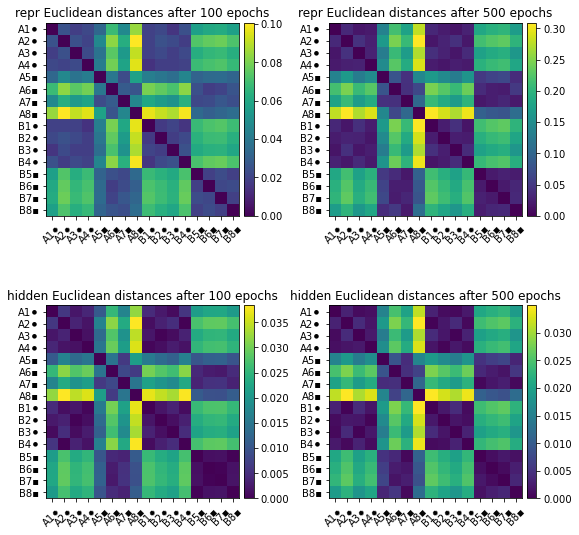

In [297]:
fig, axss = plt.subplots(2, 2, figsize=(8, 8))

for axs, (layer, layer_snaps) in zip(axss, epoch_snaps_shared.items()):
    for ax, epoch in zip(axs, [100, final_epochs]):
        rep_dist = distance.squareform(distance.pdist(layer_snaps[epoch]))
        dda.plot_matrix_with_labels(ax, rep_dist, item_names)
        ax.set_title(f'{layer} Euclidean distances after {epoch} epochs')

fig.tight_layout()
plt.show()

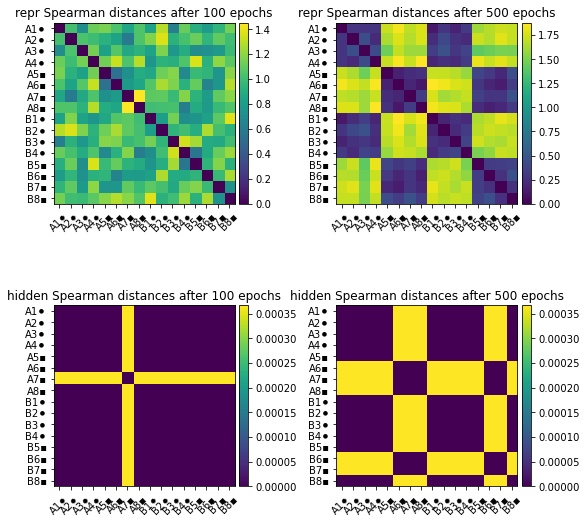

In [298]:
# get rank-order representations for each layer
rank_ord_rep = dict()
for layer, layer_snaps in epoch_snaps_shared.items():
    rank_ord_rep[layer] = dict()
    
    for epoch, snaps in layer_snaps.items():
        sort_inds_each = np.argsort(snaps, axis=1)
        rank_ord_rep[layer][epoch] = np.empty(snaps.shape)
        np.put_along_axis(rank_ord_rep[layer][epoch], sort_inds_each, range(snaps.shape[1]), axis=1)


fig, axss = plt.subplots(2, 2, figsize=(8, 8))

for axs, (layer, rank_ord_rep_layer) in zip(axss, rank_ord_rep.items()):
    for ax, epoch in zip(axs, [100, final_epochs]):
        spear_rep_dist = distance.squareform(distance.pdist(rank_ord_rep_layer[epoch], 'correlation'))
        dda.plot_matrix_with_labels(ax, spear_rep_dist, item_names)
        ax.set_title(f'{layer} Spearman distances after {epoch} epochs')
    
fig.tight_layout()
plt.show()

In [260]:
# Try looking at trajectories with PCA
# Also include 0 point for reference

%matplotlib widget
layer_snaps = [item_snaps, item_snaps_shared['repr']]
layer_names = ['All merged', 'Shared repr']
n_layers = len(layer_names)

fix, axss = plt.subplots(n_layers, 2, figsize=(10, 5*n_layers))

pca_runs = {layer_name: PCA(n_components=3) for layer_name in layer_names}

for axs, lsnaps, (name, pca) in zip(axss, layer_snaps, pca_runs.items()):
    n_snaps, n_items, n_units = lsnaps.shape
    snaps_flat = lsnaps.reshape(n_snaps * n_items, n_units)

    snaps_pc_flat = pca.fit_transform(snaps_flat)
    # break up by domain
    n_domains = net_params['n_domains']
    snaps_pc = snaps_pc_flat.reshape(n_snaps, n_domains, -1, 3)    
    zero_pc = pca.transform(np.zeros((1, n_units)))
    snaps_pc -= zero_pc
    
    # put time dimension last
    snaps_pc = snaps_pc.transpose((1, 2, 3, 0))
    
    # plot, first PC1/PC2, then PC3/PC2
    input_groups = dd.item_group(clusters=net_params['cluster_info'])
    markers = ['o', 's']
    colors = dd.get_domain_colors()
    dimss = [[0, 1], [2, 1]]

    for dom_snaps_pc, color in zip(snaps_pc, colors):
        for item_snaps_pc, group in zip(dom_snaps_pc, input_groups):
            marker = markers[group]
            fmt = marker + '-'            
            for ax, dims in zip(axs, dimss):
                ax.plot(item_snaps_pc[dims[0]], item_snaps_pc[dims[1]], fmt,
                        markersize=4, color=color)
                
                # add start/end markers
                for ind, c in zip([0, -1], ['g', 'r']):
                    ax.plot(item_snaps_pc[dims[0], ind], item_snaps_pc[dims[1], ind],
                            c + marker, markersize=8)
                    ax.plot(item_snaps_pc[dims[0], ind], item_snaps_pc[dims[1], ind],
                            marker, markersize=5, color=color)
                
    for ax, dims in zip(axs, dimss):
        # include origin just for clarity
        ax.plot(0, 0, 'xk')
        ax.set_xlabel(f'PC{dims[0] + 1}')
        ax.set_ylabel(f'PC{dims[1] + 1}')
        ax.set_title(name)
        
# add some radial lines to help visualization
# for endpt in snaps_pc[:, :, :2, -1].reshape(-1, 2):
#     axss[-1, 0].plot([endpt[0], 0], [endpt[1], 0], 'k', linewidth=0.5)
        
fig.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.05,wspace=0.3, hspace=0.3)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### PCS 1 and 2 in the last network are really interesting. Take a closer look.

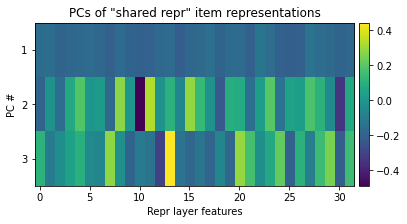

In [254]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 3))
im = ax.imshow(pca_runs['Shared repr'].components_, aspect='auto')
dda.add_colorbar(im, aspect=3)
ax.set_yticks(range(3))
ax.set_yticklabels(range(1, 4))
ax.set_ylabel('PC #')
ax.set_xlabel('Repr layer features')
ax.set_title('PCs of "shared repr" item representations')
plt.show()

### PC1 captures variance in mean activation (which is the largest by a factor of ~10).
* If HL units for circle attributes are the first to develop (due to coherent covariation or higher mean attribute frequency), it's unsurprising that circles' PC1 scores increase in magnitude early on.

### Mystery is what causes the L turn, the same across domains but in opposite directions for circles and squares (more along PC2), that causes the inter-domain Spearman checkerboard.

* Maybe a HL unit that items of a cluster in both domains can "agree on" due to context preventing activation of attributes in the wrong domain? But why does this only happen between items of the same "shape" across domains?

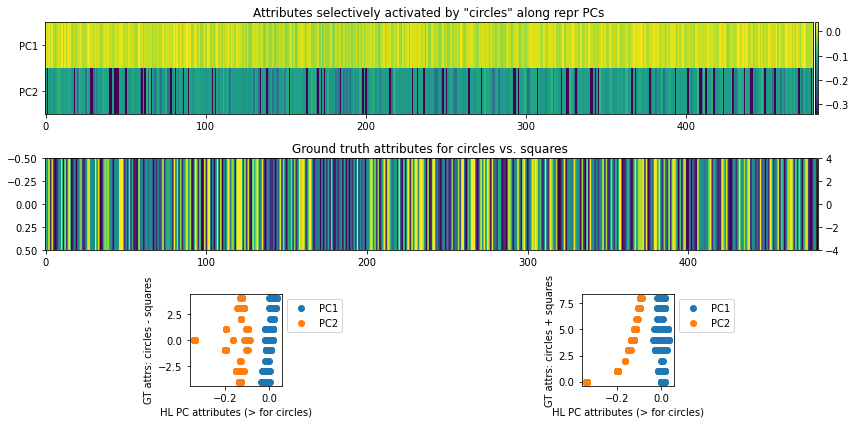

In [259]:
# try finding the attributes HL units control by summing over weights
# this is probably misguided...keep for now until I think of something better

param_dict = torch.load(net_path_shared)

with torch.no_grad():
    w_repr_hidden = param_dict['rep_to_hidden.weight'].T.cpu().numpy()
    w_hidden_attr = param_dict['hidden_to_attr.weight'].T.cpu().numpy()
    
fig, axs = plt.subplots(3, 1, figsize=(12, 6))
# negate PCS 1 and 2 because circles have more negative scores
approx_attr_circ_diff = -pca_runs['Shared repr'].components_[:2] @ w_repr_hidden @ w_hidden_attr
im = axs[0].imshow(approx_attr_circ_diff, aspect='auto', interpolation='nearest')
dda.add_colorbar(im, aspect=1)
axs[0].set_yticks(range(2))
axs[0].set_yticklabels(['PC1', 'PC2'])
axs[0].set_title('Attributes selectively activated by "circles" along repr PCs')

# Compare with the attributes for each item.
# Hypothesis is that the attributes driven by PC1 consist of common "circle" attributes from both domains.
# (Or those suppressed consist of "square" attributes)

with np.load(res_path_shared, allow_pickle=True) as resfile:
    target_attrs = resfile['ys'][0]

# compare circles vs. squares
input_inds = np.array(range(len(target_attrs)))
circ_inds = input_inds[input_inds % 8 < 4]
square_inds = input_inds[input_inds % 8 >= 4]

circ_attr_sum = np.sum(target_attrs[circ_inds, :], axis=0, keepdims=True)
square_attr_sum = np.sum(target_attrs[square_inds, :], axis=0, keepdims=True)
circ_attr_diff = circ_attr_sum - square_attr_sum
attr_total = circ_attr_sum + square_attr_sum
    
im = axs[1].imshow(circ_attr_diff, aspect='auto')
dda.add_colorbar(im, aspect=1)
axs[1].set_title("Ground truth attributes for circles vs. squares")

axs[2].remove()

# prepare for scatterplots - get everything in z-scores
a

ax_diff = fig.add_subplot(3, 2, 5)
for pcnum in range(2):
    ax_diff.scatter(approx_attr_circ_diff[pcnum], circ_attr_diff, label=f'PC{pcnum + 1}')
ax_diff.set_xlabel('repr PC  attrs (> for circles)')
ax_diff.set_ylabel('GT attrs: circles - squares')
ax_diff.set_aspect(1./ax_diff.get_data_ratio())
dda.outside_legend(ax_diff)

ax_sum = fig.add_subplot(3, 2, 6)
for pcnum in range(2):
    ax_sum.scatter(approx_attr_circ_diff[pcnum], attr_total, label=f'PC{pcnum + 1}')
ax_sum.set_xlabel('HL PC attributes (> for circles)')
ax_sum.set_ylabel('GT attrs: circles + squares')
ax_sum.set_aspect(1./ax_sum.get_data_ratio())
dda.outside_legend(ax_sum)

fig.tight_layout()
plt.show()

### So it looks like the hidden layer PC1 is not specific to "circle" attributes, but rather preferentially activates attributes in proportion to their frequency among *all* items. Makes sense in hindsight since both circles and squares have large scores for PC1; the difference is relatively small.

### Actually it's questionable whether this case really "counts" as a Spearman pattern - it's really close to just being a matter of magnitude.

## From here down is older stuff from 2021-01-18.
Mostly trying to figure out how circle and square representations differ and why in the simple all-merged network.

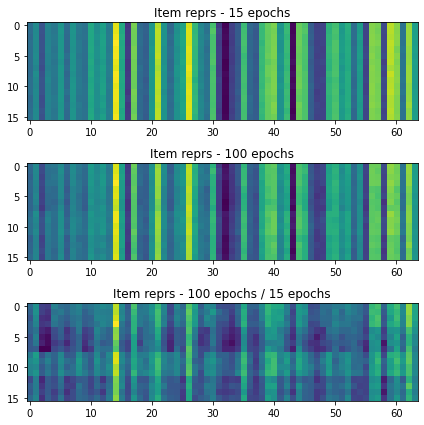

In [312]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6))
ax[0].imshow(item_snaps[3])
ax[0].set_title('Item reprs - 15 epochs')
ax[1].imshow(item_snaps[20])
ax[1].set_title('Item reprs - 100 epochs')
ax[2].imshow(item_snaps[20] / item_snaps[3])
ax[2].set_title('Item reprs - 100 epochs / 15 epochs')

fig.tight_layout()
plt.show()

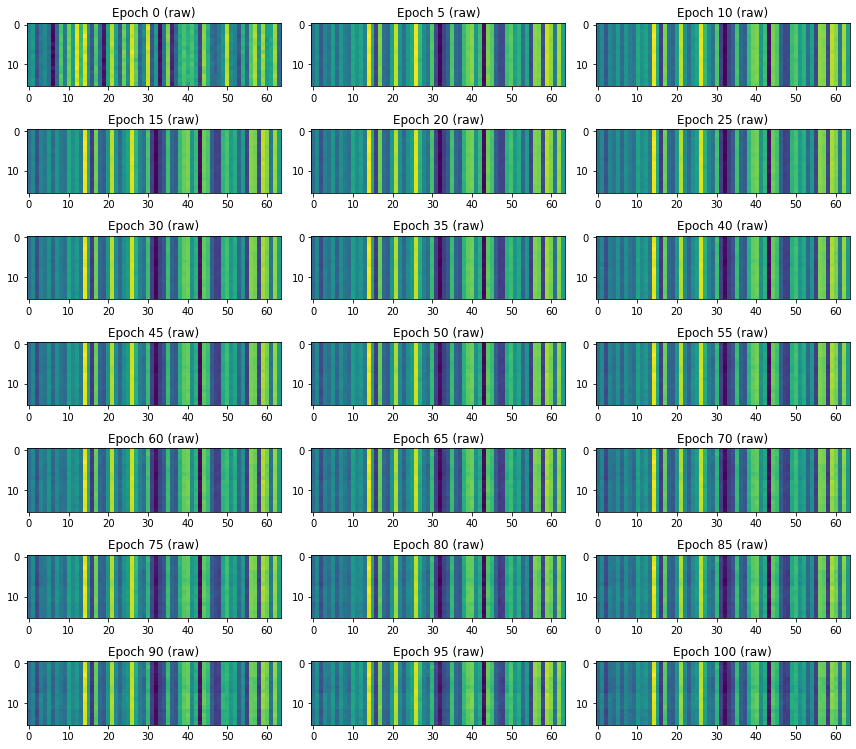

In [327]:
fig, ax = dda.make_plot_grid(21, 3, ax_dims=(4, 1.5))
for i, snaps in enumerate(item_snaps[:21]):
    ax[i].imshow(snaps)
    ax[i].set_title(f'Epoch {5 * i} (raw)')
    
fig.tight_layout()
plt.show()

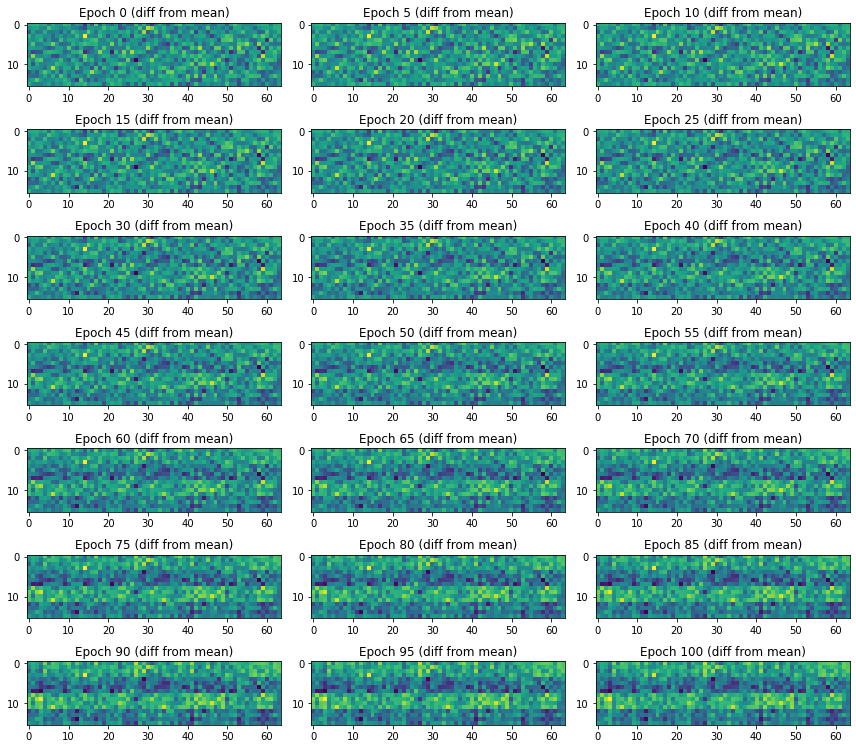

In [326]:
fig, ax = dda.make_plot_grid(21, 3, ax_dims=(4, 1.5))
for i, snaps in enumerate(item_snaps[:21]):
    ax[i].imshow(snaps - np.mean(snaps, axis=0))
    ax[i].set_title(f'Epoch {5 * i} (diff from mean)')
    
fig.tight_layout()
plt.show()

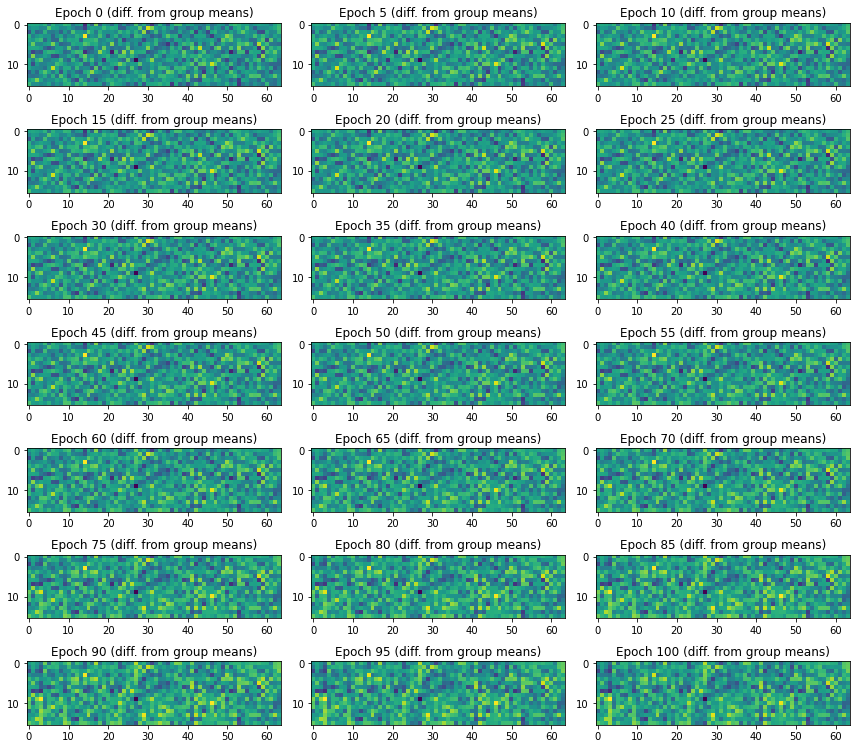

In [325]:
fig, ax = dda.make_plot_grid(21, 3, ax_dims=(4, 1.5))
for i, snaps in enumerate(item_snaps[:21]):
    im = np.empty(snaps.shape)
    for group in range(2):
        group_inds = np.concatenate([np.arange(4), np.arange(8, 12)]) + group * 4
        group_snaps = snaps[group_inds, :]
        im[group_inds, :] = group_snaps - np.mean(group_snaps, axis=0)
        
    ax[i].imshow(im)
    ax[i].set_title(f'Epoch {5 * i} (diff. from group means)')
    
fig.tight_layout()
plt.show()

<ipython-input-328-fe252148cc57>:8: RuntimeWarning: invalid value encountered in arccos
  vec_angles = np.arccos(np.dot(snaps_item_mean_norm, snaps_item_mean_norm[-1])) * 180 / np.pi


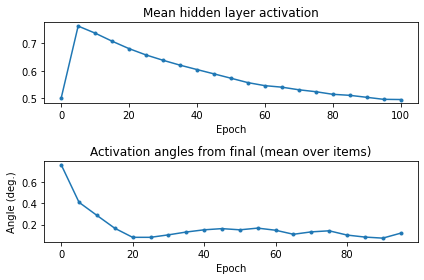

In [328]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(range(0, 101, 5), [np.mean(s) for s in item_snaps[:21]], '.-')
ax[0].set_title('Mean hidden layer activation')
ax[0].set_xlabel('Epoch')

snaps_item_mean = np.mean(item_snaps[:21], axis=1)
snaps_item_mean_norm = snaps_item_mean / np.linalg.norm(snaps_item_mean, axis=1, keepdims=True)
vec_angles = np.arccos(np.dot(snaps_item_mean_norm, snaps_item_mean_norm[-1])) * 180 / np.pi
ax[1].plot(range(0, 101, 5), vec_angles, '.-')
ax[1].set_title('Activation angles from final (mean over items)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Angle (deg.)')

fig.tight_layout()
plt.show()

### Initial jump in HL activation might be due to fixed bias of -2, so try changing it

In [112]:
res_path2 = train_n_dd_nets(n=1, run_type='2domain_weight_test_bias-1',
                            net_params={
                                'use_item_repr': False,
                                'use_ctx_repr': False,
                                'hidden_units': 64,
                                'fix_biases': True,
                                'fixed_bias': -1,
                                'n_domains': 2,
                                'cluster_info': {
                                    'clusters': '4-4',
                                    'intragroup_dists': [4, 12]
                                }
                            },
                            train_params={
                                'snap_freq': 5,
                                'report_freq': 5,
                                'num_epochs': 101
                            })[0]

In [119]:
res_path3 = train_n_dd_nets(n=1, run_type='2domain_weight_test_bias0',
                            net_params={
                            'use_item_repr': False,
                            'use_ctx_repr': False,
                            'hidden_units': 64,
                            'fix_biases': True,
                            'fixed_bias': 0,
                            'n_domains': 2,
                            'cluster_info': {
                                'clusters': '4-4',
                                'intragroup_dists': [4, 12]
                            }
                        },
                        train_params={
                            'snap_freq': 5,
                            'report_freq': 5,
                            'num_epochs': 101
                        })[0]

<ipython-input-333-ab4150b8c60f>:26: RuntimeWarning: invalid value encountered in arccos
  vec_angles = np.arccos(np.dot(snaps_item_mean_norm, snaps_item_mean_norm[-1])) * 180 / np.pi
<ipython-input-333-ab4150b8c60f>:26: RuntimeWarning: invalid value encountered in arccos
  vec_angles = np.arccos(np.dot(snaps_item_mean_norm, snaps_item_mean_norm[-1])) * 180 / np.pi


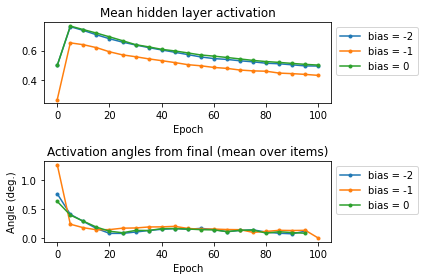

In [333]:
with np.load(res_path2, allow_pickle=True) as resfile:
    snaps2 = resfile['snapshots'].item()

with np.load(res_path3, allow_pickle=True) as resfile:
    snaps3 = resfile['snapshots'].item()

item_snaps2 = snaps2['item_hidden'][0]
item_snaps3 = snaps3['item_hidden'][0]

fig, axs = plt.subplots(2, 1)

axs[0].set_title('Mean hidden layer activation')
axs[0].set_xlabel('Epoch')

axs[1].set_title('Activation angles from final (mean over items)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Angle (deg.)')

snap_vars = [item_snaps, item_snaps2, item_snaps3]
labels = [f'bias = {bias}' for bias in [-2, -1, 0]]
for isnaps, label in zip(snap_vars, labels): 
    axs[0].plot(range(0, 101, 5), [np.mean(s) for s in isnaps[:21]], '.-', label=label)

    snaps_item_mean = np.mean(isnaps[:21], axis=1)
    snaps_item_mean_norm = snaps_item_mean / np.linalg.norm(snaps_item_mean, axis=1, keepdims=True)
    vec_angles = np.arccos(np.dot(snaps_item_mean_norm, snaps_item_mean_norm[-1])) * 180 / np.pi
    axs[1].plot(range(0, 101, 5), vec_angles, '.-', label=label)

for ax in axs:
    dda.outside_legend(ax)

fig.tight_layout()
plt.show()

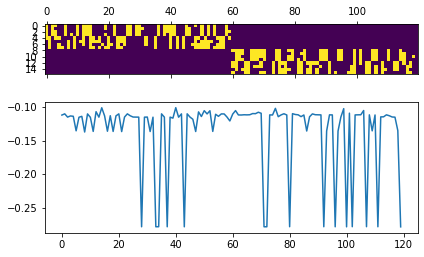

In [350]:
net_weights = torch.load(net_path)

with torch.no_grad():
    w_hidden_to_attr = net_weights['hidden_to_attr.weight'].cpu().numpy()
    
with np.load(res_path) as resfile:
    y = resfile['ys'][0]

fig, axs = plt.subplots(2, 1)
axs[0].matshow(y[24:40, 180:300])
    
mean_w = np.mean(w_hidden_to_attr, axis=1)
axs[1].plot(mean_w[180:300])
fig.tight_layout()
plt.show()

Text(0, 0.5, 'Mean weight to attribute from hidden layer')

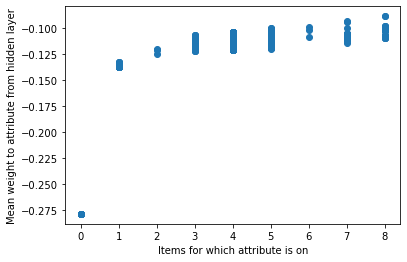

In [335]:
fig, ax = plt.subplots()
total_on = np.sum(y, axis=0)
ax.scatter(total_on, mean_w)
ax.set_xlabel('Items for which attribute is on')
ax.set_ylabel('Mean weight to attribute from hidden layer')

### Now look at hidden layer units that have strong weights toward attributes common in both domains.  Since the items aren't well differentiated yet, not sure but plausible that several would have strong weights toward attributes in both domains.

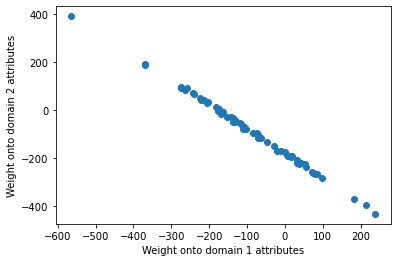

In [337]:
strength_domain1 = np.dot(total_on[:240], w_hidden_to_attr[:240])
strength_domain2 = np.dot(total_on[240:], w_hidden_to_attr[240:])

fig, ax = plt.subplots()
ax.scatter(strength_domain1, strength_domain2)
ax.set_xlabel('Weight onto domain 1 attributes')
ax.set_ylabel('Weight onto domain 2 attributes')
plt.show()

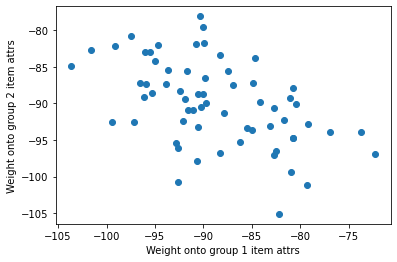

In [340]:
group1_inds = [n for n in range(y.shape[0]) if (n // 4) % 2 == 0]
group1_on = np.sum(y[group1_inds, :], axis=0)
group2_inds = [n for n in range(y.shape[0]) if (n // 4) % 2 == 1]
group2_on = np.sum(y[group2_inds, :], axis=0)

strength_group1 = np.dot(group1_on, w_hidden_to_attr)
strength_group2 = np.dot(group2_on, w_hidden_to_attr)

fig, ax = plt.subplots()
ax.scatter(strength_group1, strength_group2)
ax.set_xlabel('Weight onto group 1 item attrs')
ax.set_ylabel('Weight onto group 2 item attrs')
plt.show()

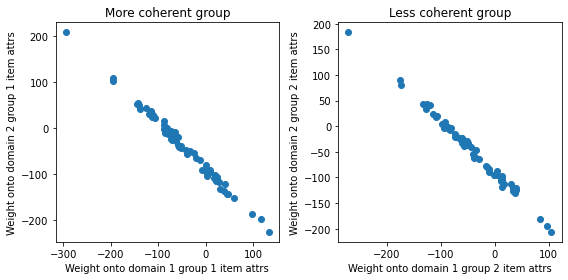

In [343]:
strength_group1_domain1 = np.dot(group1_on[:240], w_hidden_to_attr[:240])
strength_group1_domain2 = np.dot(group1_on[240:], w_hidden_to_attr[240:])
strength_group2_domain1 = np.dot(group2_on[:240], w_hidden_to_attr[:240])
strength_group2_domain2 = np.dot(group2_on[240:], w_hidden_to_attr[240:])

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(strength_group1_domain1, strength_group1_domain2)
axs[0].set_xlabel('Weight onto domain 1 group 1 item attrs')
axs[0].set_ylabel('Weight onto domain 2 group 1 item attrs')
axs[0].set_title('More coherent group')

axs[1].scatter(strength_group2_domain1, strength_group2_domain2)
axs[1].set_xlabel('Weight onto domain 1 group 2 item attrs')
axs[1].set_ylabel('Weight onto domain 2 group 2 item attrs')
axs[1].set_title('Less coherent group')

fig.tight_layout()
plt.show()

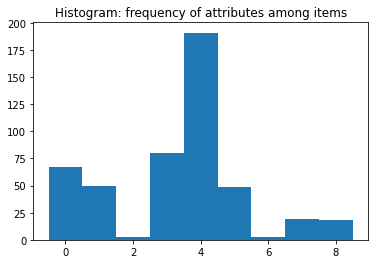

In [347]:
attr_frequency = np.sum(y, axis=0)
fig, ax = plt.subplots()
ax.hist(attr_frequency, np.arange(np.min(attr_frequency) - 0.5, np.max(attr_frequency) + 1))
ax.set_title('Histogram: frequency of attributes among items')
plt.show()

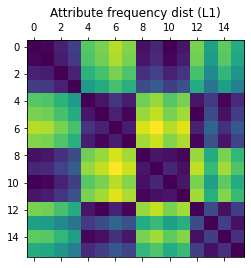

In [354]:
n_items = net_params['n_domains'] * dd.ITEMS_PER_DOMAIN
n_attributes = net_params['attrs_per_context'] * net_params['ctx_per_domain'] * net_params['n_domains']
inputs_per_domain = dd.ITEMS_PER_DOMAIN * net_params['ctx_per_domain']

y_collapsed = np.empty((n_items, n_attributes))
for i in range(n_items):
    d = i // dd.ITEMS_PER_DOMAIN
    d_offset = d * inputs_per_domain
    i_offset = i % dd.ITEMS_PER_DOMAIN
    y_collapsed[i, :] = np.sum(y[np.arange(0, inputs_per_domain, dd.ITEMS_PER_DOMAIN)
                                 + d_offset + i_offset], axis=0)

mean_attr_frequency = (y_collapsed @ attr_frequency) / np.sum(y_collapsed, axis=1)

attr_freq_dist = np.abs(mean_attr_frequency[np.newaxis, :] - mean_attr_frequency[:, np.newaxis])

fig, ax = plt.subplots()
ax.matshow(attr_freq_dist)
ax.set_title('Attribute frequency dist (L1)')
plt.show()

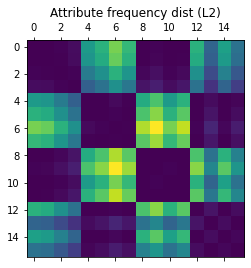

In [355]:
attr_freq_dist2 = (mean_attr_frequency[np.newaxis, :] - mean_attr_frequency[:, np.newaxis]) ** 2

fig, ax = plt.subplots()
ax.matshow(attr_freq_dist2)
ax.set_title('Attribute frequency dist (L2)')
plt.show()

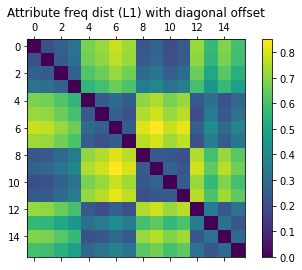

In [358]:
fig, ax = plt.subplots()
im = ax.matshow(attr_freq_dist + 0.2 * (1-np.eye(16)))
ax.set_title('Attribute freq dist (L1) with diagonal offset')
fig.colorbar(im, ax=ax)
plt.show()